# DATA

## What is this notebook about

This notebook builds upon the notebook ``` spacenet6_masking.ipynb ```

``` spacenet6_masking.ipynb ``` is used to generate all the masks for all 3401 training images, using only the PAN images and geojson_buildings files. These masks will be the same regardless of the original data format, hence it is a run-once-and-forget. 


**Take a look at the best models**

This notebook serves to take a look at the results of the best performing models. This is based on the metrics that have been logged in the metrics file. 

A visual inspection might tell us something different about the various models that we have trained. 

## Setup COLAB and imports

Mount drive to gain access to files

In [ ]:
''' Used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

Mounted at /content/gdrive


Installations required

In [ ]:
! pip install fiona
! pip install rasterio
! pip install segmentation-models

In [ ]:
''' colab recently upgraded their tensorflow packages and some stuff is breaking as of 4 Aug 2020'''
''' use this version of tensorflow for now'''
! pip install q tensorflow==2.1

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 3.9MB 41.8MB/s 
     |████████████████████████████████| 450kB 41.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=23d3fdcdee1a4827c9a9f1081e764b5eb574a2b148edd3e4749f1922c16915b0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: 

Imports required

In [ ]:
''' dealing with .tif files '''
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.plot import show, reshape_as_raster, reshape_as_image

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' core '''
import numpy as np
import pandas as pd

''' utilities '''
from tqdm import tqdm
import copy
import datetime

''' image processing '''
import tensorflow as tf
from tensorflow.keras.preprocessing import image

''' unet model '''
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.losses import JaccardLoss, BinaryFocalLoss, DiceLoss, BinaryCELoss
from segmentation_models.metrics import IOUScore, FScore

Segmentation Models: using `tf.keras` framework.


## Global

### Constants, IMG
For reference the various image types are as such (amax is a rough gauge) based on the train_all data

```
type             shape                dtype       gauge of max value    gauge of min value
PAN              (1, 900, 900)        uint16      1844                  0
PS-RGB           (3, 900, 900)        uint8       255                   0
PS-RGBNIR        (4, 900, 900)        uint16      2047                  0
RGBNIR           (4, 450, 450)        uint16      2047                  0
SAR-Intensity    (4, 900, 900)        float32     92.87763              0.0
```



In [ ]:
''' get the same sequence for random set every time '''
seed = 42
np.random.seed = seed
tf.seed = seed       

''' lookup - define image channels for each image type '''
IMG_TYPE_LOOKUP = {
    'PAN': {'channels': 1, 'dtype': np.uint16}, 
    'PS-RGB': {'channels': 3, 'dtype': np.uint8}, 
    'PS-RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'SAR-Intensity': {'channels': 4, 'dtype': np.float32}, 
}

''' image height and width we are working with for the whole notebook '''
IMG_HEIGHT = 256    
IMG_WIDTH = 256

''' root of all paths '''
PATH_SPACENET6 = Path(root_dir + '/spacenet6')
PATH_METRICS = PATH_SPACENET6/'metrics_keras_12.csv'

### SIZE, IDX
We will be setting the amount of data that we want to use for train/test
* There are 3401 images for each image type
* The actual spacenet6 "test folder" has only uneseen SAR-Intensity data

Therefore for training purposes, we will pull out our own "test data" from the training set for ease of verifying output 

Random indexes will be used for training and test

In [ ]:
''' set the various sizes we want to use '''
SIZE_ALL = 3401 
SIZE_TRAIN = 800           # CHANGE HERE
SIZE_TEST = 80            # CHANGE HERE
# 800-80, 1600-160, 3200-201

''' set the various idexes we want to use '''
try:
  TRAIN_IDX = np.load(PATH_SPACENET6/('TRAIN_IDX_'+str(SIZE_TRAIN)+'.npy'))
  TEST_IDX = np.load(PATH_SPACENET6/('TEST_IDX_'+str(SIZE_TEST)+'.npy'))
  print('TRAIN/TEST indexes available. Loading ')
except:
  ''' Generate the indexes that we will be using for train and test '''  
  ALL_IDX = np.arange(SIZE_ALL)

  TRAIN_IDX = np.random.choice(ALL_IDX, SIZE_TRAIN, replace=False)
  TRAIN_IDX.sort()

  ALL_IDX_2 = np.setdiff1d(ALL_IDX, TRAIN_IDX)

  TEST_IDX = np.random.choice(ALL_IDX_2, SIZE_TEST, replace=False)
  TEST_IDX.sort()

  np.save(PATH_SPACENET6/('TRAIN_IDX_'+str(SIZE_TRAIN)), TRAIN_IDX)
  np.save(PATH_SPACENET6/('TEST_IDX_'+str(SIZE_TEST)), TEST_IDX)
  print('TRAIN/TEST indexes not available. Generated and saved ')

TRAIN/TEST indexes available. Loading 


### Rotation file
These are the images that have been rotated

In [ ]:
TO_ROTATE = []
PATH_ORIENTATIONS = PATH_SPACENET6/'spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SummaryData/SAR_orientations.txt'

orientation_file = open(PATH_ORIENTATIONS, "r")
for line in orientation_file:
  tilename = line.split(' ')[0]
  orientation_flag = int(line.split(' ')[1])

  if orientation_flag == 1:
    TO_ROTATE.append(tilename)

TO_ROTATE.sort()

print('orientation file loaded')

orientation file loaded


## Helper functions

### rotation()

In [ ]:
def rotation(filename, img):
  try:
    if filename.split(IMG_TYPE+'_')[1].split('_tile_')[0] in TO_ROTATE:
      return np.fliplr(np.flipud(img))
    else:
      return img
  except: 
    pass

  try:
    if filename.split('Buildings_')[1].split('_tile_')[0] in TO_ROTATE:
      return np.fliplr(np.flipud(img))
    else:
      return img
  except: 
    pass
      
  
  return img

### plot_XY()

In [ ]:
def plot_XY(plotname, X, Y, X_name, Y_name, index=None):
  if index==None:
    ix = np.random.randint(0, len(X))
  else:
    ix = index
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
  show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  plt.show()

### plot_XY_preds()

In [ ]:
def plot_XY_preds(plotname, X, Y, P, X_name, Y_name, P_name, index=None):
  if index==None:
    ix = np.random.randint(0, len(X))
  else:
    ix = index
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

  if X.dtype == 'float32':
    show(reshape_as_raster(  (X[ix] - np.amin(X)) / (np.amax(X) - np.amin(X))   ), ax=ax1, title=X_name)
  else:
    show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  show(reshape_as_raster(P[ix]), ax=ax3, title=P_name)
  plt.show()

### plot_history()

In [ ]:
def plot_history(history):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

  ax1.plot(history['loss'], label='train')
  ax1.plot(history['val_loss'], label='val')
  ax1.title.set_text('loss')
  ax1.legend()

  ax2.plot(history['iou_score'], label='train')
  ax2.plot(history['val_iou_score'], label='val')
  ax2.title.set_text('iou_score')
  ax2.legend()

  ax3.plot(history['f1-score'], label='train')
  ax3.plot(history['val_f1-score'], label='val')
  ax3.title.set_text('f1-score')
  ax3.legend()

### store_metrics()
Save into the metrics file

In [ ]:
try: 
  METRICS_HISTORY = pd.read_csv(PATH_METRICS)
except:
  TIMESTAMP = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS = 'trial', 'trial', 'trial', 'trial', 'trial', 'trial', 'trial'
  MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST, train_loss, train_iou_score, train_f1_score, val_loss, val_iou_score, val_f1_score, test_loss, test_iou_score, test_f1_score = 0,0,0,0,0,0,0,0,0,0,0,0,0

  METRICS_HISTORY = pd.DataFrame(np.array([[TIMESTAMP, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST, 
                              test_loss, test_iou_score, test_f1_score,
                              val_loss, val_iou_score, val_f1_score, 
                              train_loss, train_iou_score, train_f1_score
                              ]]),
                    columns=['timestamp', 'img_type', 'img_rotated', 'model_name', 'model_type', 'pretrain', 'loss_function', 'comments', 'batch_size', 'epochs', 'size_train', 'size_test', 
                              'test_loss', 'test_iou_score', 'test_f1-score',
                              'val_loss', 'val_iou_score', 'val_f1-score', 
                              'train_loss', 'train_iou_score', 'train_f1-score'
                              ],
                    )
  METRICS_HISTORY.to_csv(PATH_METRICS, index=False)

In [ ]:
def store_metrics(test_loss, test_iou_score, test_f1_score, val_loss, val_iou_score, val_f1_score, train_loss, train_iou_score, train_f1_score, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST, PATH_METRICS):
  TIMESTAMP = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

  ''' create another df that looks just like that and concat with ''' 
  new_metrics = pd.DataFrame(np.array([[TIMESTAMP, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST,
                             test_loss, test_iou_score, test_f1_score,
                             val_loss, val_iou_score, val_f1_score, 
                             train_loss, train_iou_score, train_f1_score                             
                             ]]),
                   columns=['timestamp', 'img_type', 'img_rotated', 'model_name', 'model_type', 'pretrain', 'loss_function', 'comments', 'batch_size', 'epochs', 'size_train', 'size_test', 
                            'test_loss', 'test_iou_score', 'test_f1-score',
                            'val_loss', 'val_iou_score', 'val_f1-score',
                            'train_loss', 'train_iou_score', 'train_f1-score'                            
                            ],
                  )

  new_metrics.to_csv(PATH_METRICS, mode='a', header=False, index=False)
  print("saved model metrics")

## Generator

### gen_input_image_details()
Set the specifications for the image input into the model

In [ ]:
def gen_input_image_details(IMG_TYPE, IMG_ROTATED, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_TYPE_LOOKUP=IMG_TYPE_LOOKUP):
  print('gen_input_image_details()')
  
  IMG_CHANNELS = IMG_TYPE_LOOKUP[IMG_TYPE]['channels']
  IMG_DTYPE_SRC = IMG_TYPE_LOOKUP[IMG_TYPE]['dtype']
  IMG_DTYPE = np.uint8               

  print('IMG_TYPE: {}, IMG_HEIGHT: {}, IMG_WIDTH: {}, IMG_ROTATED: {}, IMG_CHANNELS: {}, IMG_DTYPE_SRC: {}, IMG_DTYPE: {}\n'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE))

  return (IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE)

### gen_paths()
Setting the paths that we require, which will change based on the image type and image size specified

In [ ]:
def gen_paths(IMG_TYPE, IMG_ROTATED, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH):
  print('gen_paths()')

  ''' set the original data source folder '''
  PATH_SRC = PATH_SPACENET6/'spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam'
  PATH_SRC_IMAGE = PATH_SRC/IMG_TYPE
  PATH_SRC_MASK = PATH_SRC/'_mask'


  ''' change in accordance to the image type and dimensions '''
  COMBI = IMG_TYPE + '_' + str(IMG_HEIGHT) + 'x' + str(IMG_WIDTH)


  ''' set the directories for this combination '''
  if IMG_ROTATED:
    PATH_DATA = PATH_SPACENET6/('spacenet6_data_rotated/' + COMBI)
    PATH_DATA.mkdir(parents=True, exist_ok=True)
  else:
    PATH_DATA = PATH_SPACENET6/('spacenet6_data/' + COMBI)
    PATH_DATA.mkdir(parents=True, exist_ok=True)

  PATH_IMAGE = PATH_DATA/'image'
  PATH_IMAGE.mkdir(parents=True, exist_ok=True)

  PATH_MASK = PATH_DATA/'mask'
  PATH_MASK.mkdir(parents=True, exist_ok=True)

  PATH_SAMPLE = PATH_DATA/'sample'
  PATH_SAMPLE.mkdir(parents=True, exist_ok=True)

  PATH_SAVED_MODELS = PATH_DATA/'saved_models'
  PATH_SAVED_MODELS.mkdir(parents=True, exist_ok=True)

  print('PATH_SRC: {}, \nPATH_SRC_IMAGE: {}, \nPATH_SRC_MASK: {}, \nPATH_DATA: {}, \nPATH_IMAGE: {}, \nPATH_MASK: {}, \nPATH_SAMPLE: {}, \nPATH_SAVED_MODELS: {}\n'.format(PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS))

  return (PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS)

### gen_resized_images()
This will check if the required resized images have already been created. If not, it will create it.

In [ ]:
def gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH):
  print('gen_resized_images()')
  
  
  def resize_and_save(img_src_path, img_fname, img_save_path):
    img = rasterio.open(img_src_path/img_fname)

    ''' use the metadata from the original image '''
    transform = img.transform
    meta = img.meta.copy()

    ''' resize the image '''
    resized_img = img.read()
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))
    resized_img = reshape_as_image(resized_img)
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

    resized_img = tf.image.resize(resized_img, [IMG_HEIGHT, IMG_WIDTH], method='nearest', preserve_aspect_ratio=True, antialias=True)
    resized_img = reshape_as_raster(resized_img)
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

    resized_img = rotation(img_fname, resized_img)


    ''' update metadata with new size '''
    meta.update({"transform": transform,
                "height": resized_img.shape[1],
                "width": resized_img.shape[2]
                })

    ''' write the resized image to a new geotiff '''
    with rasterio.open(img_save_path/img_fname, 'w', **meta) as dst:
      dst.write(resized_img)




  ''' Verify contents in source directory are present and assign to iterator '''
  src_image_ids = next(os.walk(PATH_SRC_IMAGE))[2]
  src_image_ids.sort()
  # print('len(src_image_ids): {}'.format(len(src_image_ids)))
  # print(src_image_ids[:3])

  src_mask_ids = next(os.walk(PATH_SRC_MASK))[2]
  src_mask_ids.sort()
  # print('len(src_mask_ids): {}'.format(len(src_mask_ids)))
  # print(src_mask_ids[:3])


  ''' check the target directory for existing files '''
  existing_image_ids = next(os.walk(PATH_IMAGE))[2]
  existing_image_ids.sort()
  # print('len(existing_image_ids): {}'.format(len(existing_image_ids)))
  # print(existing_image_ids[:3])

  existing_mask_ids = next(os.walk(PATH_MASK))[2]
  existing_mask_ids.sort()
  # print('len(existing_mask_ids): {}'.format(len(existing_mask_ids)))
  # print(existing_mask_ids[:3])


  ''' check if resized files already exist, else create them '''
  if (existing_image_ids == src_image_ids) and (existing_mask_ids == src_mask_ids): 
    print('Resized images and masks available\n')
    pass
  else:
    print('Resized images and masks not available')
    print('Resizing image')
    for n, id in tqdm(enumerate(src_image_ids), total=len(src_image_ids), position=0, leave=True):
      resize_and_save(PATH_SRC_IMAGE, id, PATH_IMAGE)
    print('Finished resizing image')

    print('Resizing mask')
    for n, id in tqdm(enumerate(src_mask_ids), total=len(src_mask_ids), position=0, leave=True):
      resize_and_save(PATH_SRC_MASK, id, PATH_MASK)
    print('Finished resizing mask')

    print('Resized images and masks generated\n')

### gen_train_test_set()
This will return the train test set 

In [ ]:
def gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_CHANNELS, IMG_DTYPE_SRC, TRAIN_IDX, TEST_IDX, SIZE_TRAIN=SIZE_TRAIN, SIZE_TEST=SIZE_TEST, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH):
  print('gen_train_test_set()')  
  
  X_train_sample_fname = 'sample_X_train_{}.npy'.format(SIZE_TRAIN)
  Y_train_sample_fname = 'sample_Y_train_{}.npy'.format(SIZE_TRAIN)
  X_test_sample_fname = 'sample_X_test_{}.npy'.format(SIZE_TEST)
  Y_test_sample_fname = 'sample_Y_test_{}.npy'.format(SIZE_TEST)
  
  
  ''' load sample data if present '''
  try:
    X_train = np.load(PATH_SAMPLE/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
    Y_train = np.load(PATH_SAMPLE/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))
    X_test = np.load(PATH_SAMPLE/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
    Y_test = np.load(PATH_SAMPLE/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))
    print('Sample data available. Loaded sample data\n')

  except:
    ''' get the ids/filenames that we need, based on the random index allocation to avoid grouping '''
    ''' X are image files, Y are mask files '''
    print('Sample data not available')
    all_img_ids = next(os.walk(PATH_IMAGE))[2]
    all_img_ids.sort()
    all_img_ids = np.array(all_img_ids)

    all_mask_ids = next(os.walk(PATH_MASK))[2]
    all_mask_ids.sort()
    all_mask_ids = np.array(all_mask_ids)

    X_train_ids = all_img_ids[TRAIN_IDX]
    X_train_ids.sort()
    Y_train_ids = all_mask_ids[TRAIN_IDX]
    Y_train_ids.sort()

    X_test_ids = all_img_ids[TEST_IDX]
    X_test_ids.sort()
    Y_test_ids = all_mask_ids[TEST_IDX]
    Y_test_ids.sort()

    # print(len(all_img_ids))
    # print(all_img_ids[:3])
    # print(len(all_mask_ids))
    # print(all_mask_ids[:3])
    # print(len(X_train_ids))
    # print(X_train_ids[:3])
    # print(len(Y_train_ids))
    # print(Y_train_ids[:3])
    # print(len(X_test_ids))
    # print(X_test_ids[:3])
    # print(len(Y_test_ids))
    # print(Y_test_ids[:3])


    ''' prepare numpy arrays to store converted image and mask files. Image files will need to be converted to IMG_DTYPE_SRC and mask files will be converted to np.bool '''
    X_train = np.zeros((len(X_train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) 
    Y_train = np.zeros((len(Y_train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    X_test = np.zeros((len(X_test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) 
    Y_test = np.zeros((len(Y_test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    # print('X_train', X_train.shape, X_train.dtype)
    # print('Y_train', Y_train.shape, Y_train.dtype)
    # print('X_test', X_test.shape, X_test.dtype)
    # print('Y_test', Y_test.shape, Y_test.dtype)

    ''' actually format the imaegs into the correct data shape and type '''
    print('formatting training images')
    for n, id in tqdm(enumerate(X_train_ids), total=len(X_train_ids), position=0, leave=True):
      img = rasterio.open(PATH_IMAGE/id).read()
      img = reshape_as_image(img)
      X_train[n] = img
    print('Finished formatting training images')

    print('formatting training masks')
    for n, id in tqdm(enumerate(Y_train_ids), total=len(Y_train_ids), position=0, leave=True):
      img = rasterio.open(PATH_MASK/id).read()
      img = reshape_as_image(img)
      img = img.astype(np.bool) 
      Y_train[n] = img
    print('Finished formatting training masks')

    print('formatting test images')
    for n, id in tqdm(enumerate(X_test_ids), total=len(X_test_ids), position=0, leave=True):
      img = rasterio.open(PATH_IMAGE/id).read()
      img = reshape_as_image(img)
      X_test[n] = img
    print('Finished formatting test images')

    print('formatting test masks')
    for n, id in tqdm(enumerate(Y_test_ids), total=len(Y_test_ids), position=0, leave=True):
      img = rasterio.open(PATH_MASK/id).read()
      img = reshape_as_image(img)
      img = img.astype(np.bool) 
      Y_test[n] = img
    print('Finished formatting test masks')  


    np.save(PATH_SAMPLE/X_train_sample_fname, X_train.ravel())
    np.save(PATH_SAMPLE/Y_train_sample_fname, Y_train.ravel())
    np.save(PATH_SAMPLE/X_test_sample_fname, X_test.ravel())
    np.save(PATH_SAMPLE/Y_test_sample_fname, Y_test.ravel())

    print('Sample data generated and saved\n')

  return (X_train, Y_train, X_test, Y_test)

### gen_model()
This will generate a basic model to use 

In [ ]:
def gen_model(MODEL_LOSS, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_CHANNELS, MODEL_ID=None, MODEL_COMMENTS=''): 
  MODEL_OPTIMIZER = 'adam'
  MODEL_LOSS = JaccardLoss()                                      # CHANGE HERE
  MODEL_METRICS =[IOUScore(), FScore()]
  MODEL_VAL_SPLIT = 0.1
  MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))    
  MODEL_BATCH_SIZE = MODEL_BATCH_SIZE
  MODEL_EPOCHS = MODEL_EPOCHS                                               # CHANGE HERE

  MODEL_TYPE = 'segmentation-models Unet'
  MODEL_PRETRAIN = MODEL_PRETRAIN                                     # CHANGE HERE
  MODEL_LOSS_FUNCTION = MODEL_LOSS_FUNCTION                           # CHANGE HERE
  MODEL_COMMENTS = MODEL_COMMENTS

  if MODEL_ID == None:
    MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)
  else:
    MODEL_NAME = 'ID_{}__MODEL_{}__PRETRAIN_{}__LOSS_{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_ID, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

  model = Unet(backbone_name=MODEL_PRETRAIN, encoder_weights=None, input_shape=(None, None, IMG_CHANNELS))
  model.compile(optimizer=MODEL_OPTIMIZER, loss=MODEL_LOSS, metrics=MODEL_METRICS)

  return (MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, MODEL_VAL_SPLIT, MODEL_VAL_OFFSET, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_ID, MODEL_NAME, model)


### gen_model_results()
This will generate a basic model to use 

In [ ]:
def gen_model_results(PATH_SAVED_MODELS, MODEL_NAME, X_train, Y_train, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_VAL_SPLIT, load_weights_filename='', load_weights_epochs=0, save_model=False):
  checkpointer = tf.keras.callbacks.ModelCheckpoint( PATH_SAVED_MODELS/(MODEL_NAME+'_WEIGHTS.h5'), verbose=1, save_best_only=True)
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', mode='min')]   

  if load_weights_filename == '':
    print('No weights loaded. Training new model')
    results = model.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT, callbacks=callbacks)
  else:
    model.load_weights(str(PATH_SAVED_MODELS/load_weights_filename))

    # load_weights_epochs: the extra epochs to train for, after loading in weights. 
    if load_weights_epochs == 0:
      print('Just loading weights')
      results = None
    else:
      print('Weights loaded, training for extra {} epochs'.format(load_weights_epochs))
      results = model.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=load_weights_epochs, validation_split=MODEL_VAL_SPLIT, callbacks=callbacks)

  if save_model == True:
    # model.save(str(PATH_SAVED_MODELS/(MODEL_NAME+'.h5')))
    model.save_weights(str(PATH_SAVED_MODELS/(MODEL_NAME+'_WEIGHTS.h5')))
    print('model saved')
  
  return (results, model)

### gen_predictions()
This will generate the predictions based on a trained model

In [ ]:
def gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN=SIZE_TRAIN, SIZE_TEST=SIZE_TEST, PATH_METRICS=PATH_METRICS):
  ''' split train, val 90-10. validation_split takes the percentage from the back '''
  preds_train = model.predict(X_train[:MODEL_VAL_OFFSET], verbose=1)
  preds_val = model.predict(X_train[MODEL_VAL_OFFSET:], verbose=1)
  preds_test = model.predict(X_test, verbose=1)

  preds_train_t = (preds_train > 0.5).astype(np.uint8)
  preds_val_t = (preds_val > 0.5).astype(np.uint8)
  preds_test_t = (preds_test > 0.5).astype(np.uint8)


  ''' evaluation of prediction '''
  metric_names = model.metrics_names
  
  print("train set evaluation")
  train_metrics = model.evaluate(X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET])
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', train_metrics[x])

  print("\nvalidation set evaluation")
  val_metrics = model.evaluate(X_train[MODEL_VAL_OFFSET:], X_train[MODEL_VAL_OFFSET:])
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', val_metrics[x])

  print("\ntest set evaluation")
  test_metrics = model.evaluate(X_test, Y_test)
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', test_metrics[x])

  store_metrics(test_metrics[0], test_metrics[1], test_metrics[2], val_metrics[0], val_metrics[1], val_metrics[2], train_metrics[0], train_metrics[1], train_metrics[2], IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

  return (preds_train_t, preds_val_t, preds_test_t)

# SAVE BEST MODELS PREDICTIONS

## Load in desired data set for evaluation

This can be anything, either some of the pre-generated data, all of the data, or any random set. The X set will be the source picture, the Y set will be the ground truth mask of buildings 

This is manual loading, it depends on what data you want to to use the model to predict 



In [ ]:
''' this is the 3200 image subset of the 3401 train images'''
X_eval = np.load(PATH_SPACENET6/'spacenet6_data/SAR-Intensity_256x256/sample/sample_X_train_3200.npy').reshape((3200,256,256,4))
Y_eval = np.load(PATH_SPACENET6/'spacenet6_data/SAR-Intensity_256x256/sample/sample_Y_train_3200.npy').reshape((3200,256,256,1))

Y_eval = Y_eval.astype(np.float32)

## Evaluation functions

### eval_predictions()
Get predictions for the evaluation set

In [ ]:
def eval_predictions(model, X_eval, Y_eval):
  preds_eval = model.predict(X_eval, verbose=1)
  preds_eval_t = (preds_eval > 0.5).astype(np.uint8)

  metric_names = model.metrics_names

  print("eval set evaluation")
  eval_metrics = model.evaluate(X_eval, Y_eval)
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', eval_metrics[x])

  return (preds_eval_t)

### eval_models_preds()

In [ ]:
def eval_models_preds(plotname, X, Y, P, X_name, Y_name, P_name, index=None):
  if index==None:
    ix = np.random.randint(0, len(X))
  else:
    ix = index
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

  if X.dtype == 'float32':
    show(reshape_as_raster(  (X[ix] - np.amin(X)) / (np.amax(X) - np.amin(X))   ), ax=ax1, title=X_name)
  else:
    show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  show(reshape_as_raster(P[ix]), ax=ax3, title=P_name)
  plt.show()  

### eval_top_models_preds()

In [ ]:
def eval_top_models_preds(plotname, X, Y, P1, P2, P3, X_name, Y_name, P1_name, P2_name, P3_name, index=None):
  if index==None:
    ix = np.random.randint(0, len(X))
  else:
    ix = index
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20,8))

  if X.dtype == 'float32':
    show(reshape_as_raster(  (X[ix] - np.amin(X)) / (np.amax(X) - np.amin(X))   ), ax=ax1, title=X_name)
  else:
    show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  show(reshape_as_raster(P1[ix]), ax=ax3, title=P1_name)
  show(reshape_as_raster(P2[ix]), ax=ax4, title=P2_name)
  show(reshape_as_raster(P3[ix]), ax=ax5, title=P3_name)
  plt.show()  

## Load in desired models

These will be the best performing models. The issue here is this - although we do have the .h5 files for every single model, we are unable to load them directly for some reason. Therefore the only way is to recreate the code for the model that we want, and then load in the weights.h5 file into the recreated model. 

Make sure to rename the model variable accordingly so we can keep all the models in memory. Use the ID as a reference

**This is manual loading as well**

Find the relevant code to recreate the model from the various notebooks

### ID 137

In [ ]:
''' recreate the model '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', False)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS = gen_paths(IMG_TYPE, IMG_ROTATED)
MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, MODEL_VAL_SPLIT, MODEL_VAL_OFFSET, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_ID, MODEL_NAME, model_ID_137 = gen_model(
    BinaryFocalLoss(alpha=0.75, gamma=0.25), 4, 100, 'segmentation-models Unet', 'resnet50', 'BinaryFocalLoss(alpha=0.75, gamma=0.25)', IMG_CHANNELS, MODEL_ID=137, MODEL_COMMENTS='resnet50 test')          # CHANGE HERE

''' load weights into recreated model '''
model_ID_137.load_weights(str(PATH_SAVED_MODELS/'ID_137__MODEL_segmentation-models Unet__PRETRAIN_resnet50__LOSS_BinaryFocalLoss(alpha=0.75, gamma=0.25)__EPOCH_100__TRAIN_800__TEST_80_WEIGHTS.h5'))

''' predict using model '''
preds_eval_t_ID_137 = eval_predictions(model_ID_137, X_eval, Y_eval)

gen_input_image_details()
IMG_TYPE: SAR-Intensity, IMG_HEIGHT: 256, IMG_WIDTH: 256, IMG_ROTATED: False, IMG_CHANNELS: 4, IMG_DTYPE_SRC: <class 'numpy.float32'>, IMG_DTYPE: <class 'numpy.uint8'>

gen_paths()
PATH_SRC: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam, 
PATH_SRC_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity, 
PATH_SRC_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/_mask, 
PATH_DATA: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256, 
PATH_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/image, 
PATH_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/mask, 
PATH_SAMPLE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/sample, 
P

index: 2092
eval preds  set


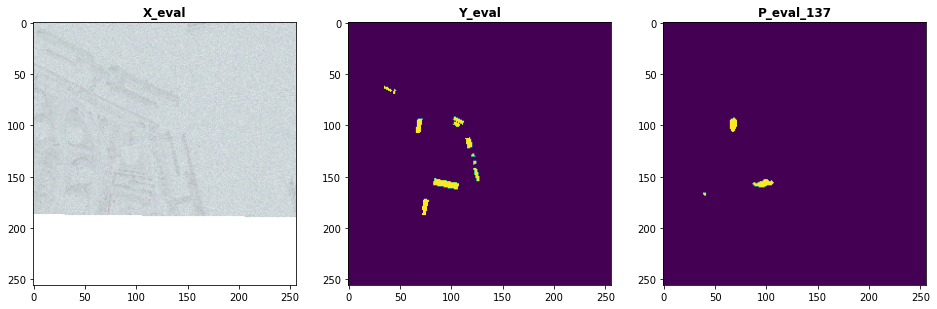

index: 3021
eval preds  set


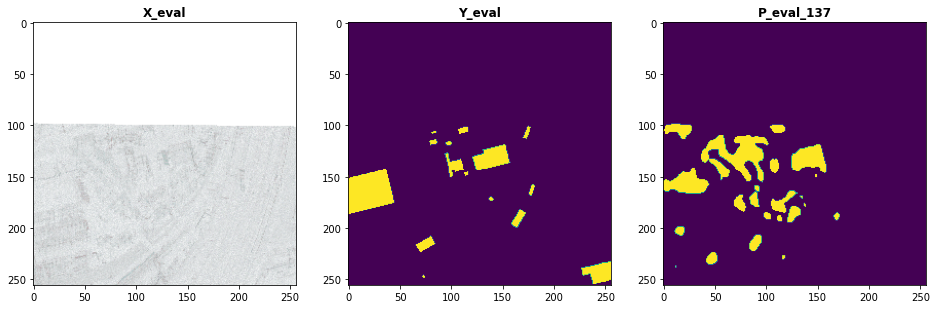

index: 1674
eval preds  set


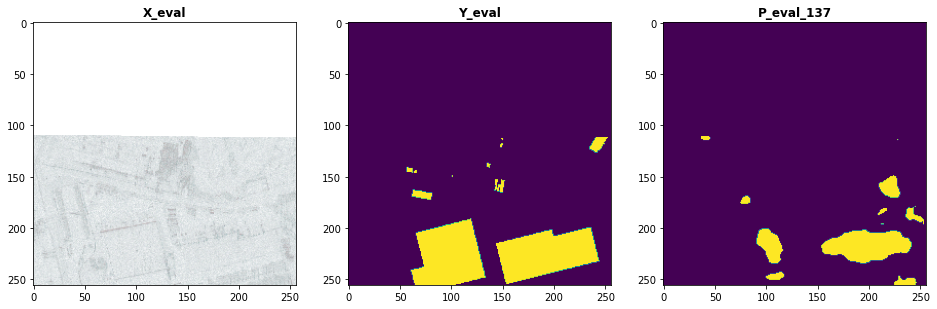

In [ ]:
''' plot predictions to visualize ''' 
eval_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, 'X_eval', 'Y_eval', 'P_eval_137')
eval_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, 'X_eval', 'Y_eval', 'P_eval_137')
eval_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, 'X_eval', 'Y_eval', 'P_eval_137')

### ID 136

In [ ]:
''' recreate the model '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', False)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS = gen_paths(IMG_TYPE, IMG_ROTATED)
MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, MODEL_VAL_SPLIT, MODEL_VAL_OFFSET, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_ID, MODEL_NAME, model_ID_136 = gen_model(
    BinaryCELoss(), 4, 100, 'segmentation-models Unet', 'resnet50', 'BinaryCELoss()', IMG_CHANNELS, MODEL_ID=136, MODEL_COMMENTS='resnet50 test')          # CHANGE HERE

''' load weights into recreated model '''
model_ID_136.load_weights(str(PATH_SAVED_MODELS/'ID_136__MODEL_segmentation-models Unet__PRETRAIN_resnet50__LOSS_BinaryCELoss()__EPOCH_100__TRAIN_800__TEST_80_WEIGHTS.h5'))

''' predict using model '''
preds_eval_t_ID_136 = eval_predictions(model_ID_136, X_eval, Y_eval)

gen_input_image_details()
IMG_TYPE: SAR-Intensity, IMG_HEIGHT: 256, IMG_WIDTH: 256, IMG_ROTATED: False, IMG_CHANNELS: 4, IMG_DTYPE_SRC: <class 'numpy.float32'>, IMG_DTYPE: <class 'numpy.uint8'>

gen_paths()
PATH_SRC: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam, 
PATH_SRC_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity, 
PATH_SRC_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/_mask, 
PATH_DATA: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256, 
PATH_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/image, 
PATH_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/mask, 
PATH_SAMPLE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/sample, 
P

index: 500
eval preds  set


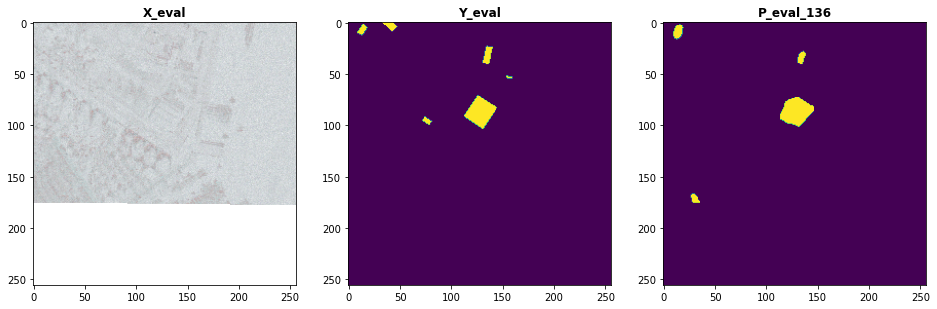

index: 125
eval preds  set


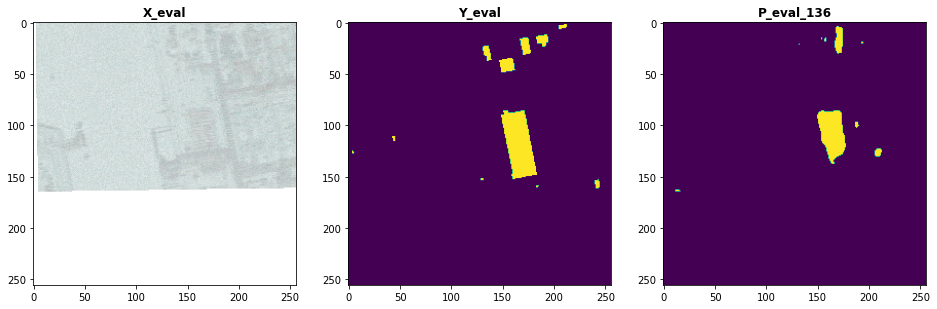

index: 818
eval preds  set


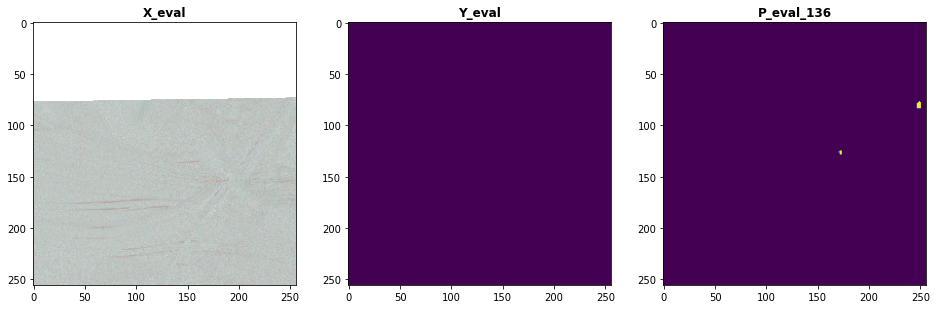

In [ ]:
''' plot predictions to visualize ''' 
eval_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_136, 'X_eval', 'Y_eval', 'P_eval_136')
eval_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_136, 'X_eval', 'Y_eval', 'P_eval_136')
eval_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_136, 'X_eval', 'Y_eval', 'P_eval_136')

### ID 134

In [ ]:
''' recreate the model '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', False)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS = gen_paths(IMG_TYPE, IMG_ROTATED)
MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, MODEL_VAL_SPLIT, MODEL_VAL_OFFSET, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_ID, MODEL_NAME, model_ID_134 = gen_model(
    DiceLoss(beta=1.25), 4, 100, 'segmentation-models Unet', 'resnet50', 'DiceLoss(beta=1.25)', IMG_CHANNELS, MODEL_ID=134, MODEL_COMMENTS='resnet50 test')          # CHANGE HERE

''' load weights into recreated model '''
model_ID_134.load_weights(str(PATH_SAVED_MODELS/'ID_134__MODEL_segmentation-models Unet__PRETRAIN_resnet50__LOSS_DiceLoss(beta=1.25)__EPOCH_100__TRAIN_800__TEST_80_WEIGHTS.h5'))

''' predict using model '''
preds_eval_t_ID_134 = eval_predictions(model_ID_134, X_eval, Y_eval)

gen_input_image_details()
IMG_TYPE: SAR-Intensity, IMG_HEIGHT: 256, IMG_WIDTH: 256, IMG_ROTATED: False, IMG_CHANNELS: 4, IMG_DTYPE_SRC: <class 'numpy.float32'>, IMG_DTYPE: <class 'numpy.uint8'>

gen_paths()
PATH_SRC: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam, 
PATH_SRC_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity, 
PATH_SRC_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/_mask, 
PATH_DATA: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256, 
PATH_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/image, 
PATH_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/mask, 
PATH_SAMPLE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/sample, 
P

index: 3190
eval preds  set


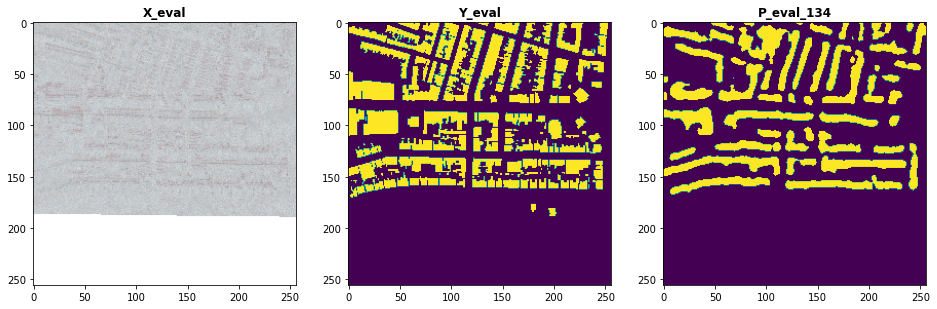

index: 1912
eval preds  set


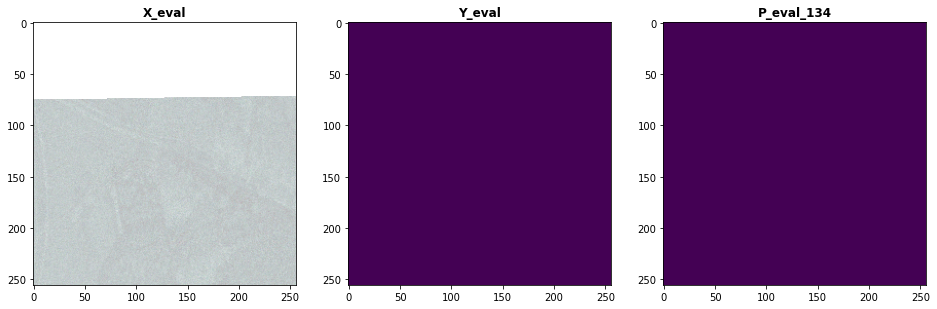

index: 2981
eval preds  set


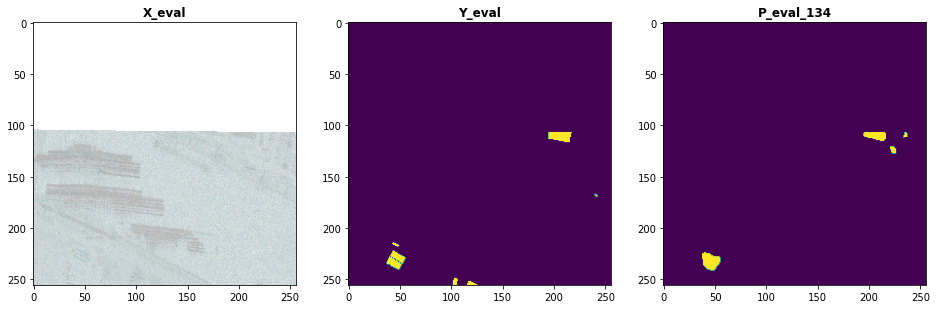

In [ ]:
''' plot predictions to visualize ''' 
eval_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_134')
eval_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_134')
eval_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_134')

### Top three

index: 1666
eval preds  set


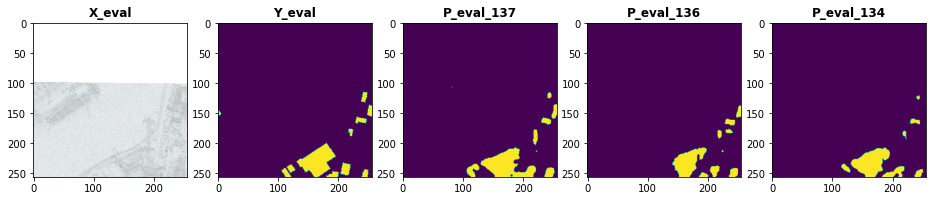

index: 2503
eval preds  set


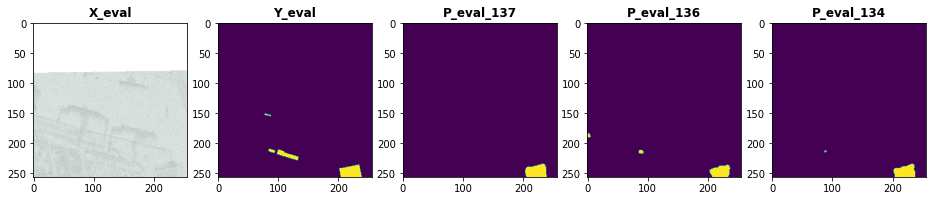

index: 2824
eval preds  set


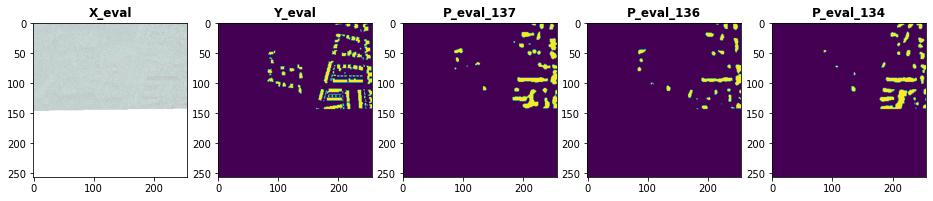

In [ ]:
''' plot predictions to visualize ''' 
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134')
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134')
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134')

### Save predictions for easier retrieval

In [ ]:
PATH_PREDS = PATH_SPACENET6/'preds'
PATH_PREDS.mkdir(parents=True, exist_ok=True)

In [ ]:
np.save(PATH_PREDS/'PREDS_ID_137__X_train_3200', preds_eval_t_ID_137)
np.save(PATH_PREDS/'PREDS_ID_136__X_train_3200', preds_eval_t_ID_136)
np.save(PATH_PREDS/'PREDS_ID_134__X_train_3200', preds_eval_t_ID_134)

# ANALYSE PREDICTIONS

## Load in desired data set for evaluation

This can be anything, either some of the pre-generated data, all of the data, or any random set. The X set will be the source picture, the Y set will be the ground truth mask of buildings 



In [ ]:
''' this is the 3200 image subset of the 3401 train images'''
X_eval = np.load(PATH_SPACENET6/'spacenet6_data/SAR-Intensity_256x256/sample/sample_X_train_3200.npy').reshape((3200,256,256,4))
Y_eval = np.load(PATH_SPACENET6/'spacenet6_data/SAR-Intensity_256x256/sample/sample_Y_train_3200.npy').reshape((3200,256,256,1))

## Load in predictions and look at them

In [ ]:
PATH_PREDS = PATH_SPACENET6/'preds'
preds_eval_t_ID_137 = np.load(PATH_PREDS/'PREDS_ID_137__X_train_3200.npy')
preds_eval_t_ID_136 = np.load(PATH_PREDS/'PREDS_ID_136__X_train_3200.npy')
preds_eval_t_ID_134 = np.load(PATH_PREDS/'PREDS_ID_134__X_train_3200.npy')

X_eval: SAR image

Y_eval: ground truth mask

### 0 to 500

In [ ]:
for x in range(0,500):
  eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=x)

Output hidden; open in https://colab.research.google.com to view.

### 500 to 1000

In [ ]:
for x in range(500,1000):
  eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=x)

Output hidden; open in https://colab.research.google.com to view.

### 1000 to 1500

In [ ]:
for x in range(1000,1500):
  eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=x)

Output hidden; open in https://colab.research.google.com to view.

### 1500 to 2000

In [ ]:
for x in range(1500,2000):
  eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=x)

### 2000 to 2500

In [ ]:
for x in range(2000,2500):
  eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=x)

### 2500 to 3000

In [ ]:
for x in range(2500,3000):
  eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=x)

### 3000 to 3200

In [ ]:
for x in range(3000,3200):
  eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=x)

Output hidden; open in https://colab.research.google.com to view.

## Look at some of the findings from the predictions

### Blobby predictions
The model has some difficulties predicting geometric shapes that are characteristic of buildings, for instance sharp edges, corners, lines. This is something that can be worked on. While the general area of prediction is correct, the shape is off

Notice the rounded edges, generally correct area but 'blobbly shape'

This is not exactly a major problem if we are looking for the general area that buildings are in, but for an accurate building map and grouping of objectives, this will pose a challenge

index: 2
eval preds  set


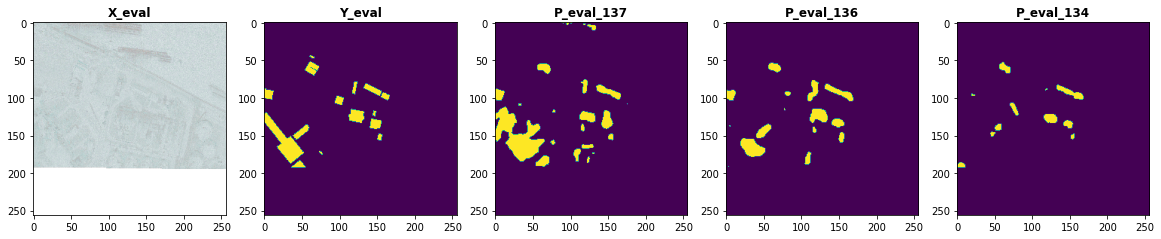

index: 49
eval preds  set


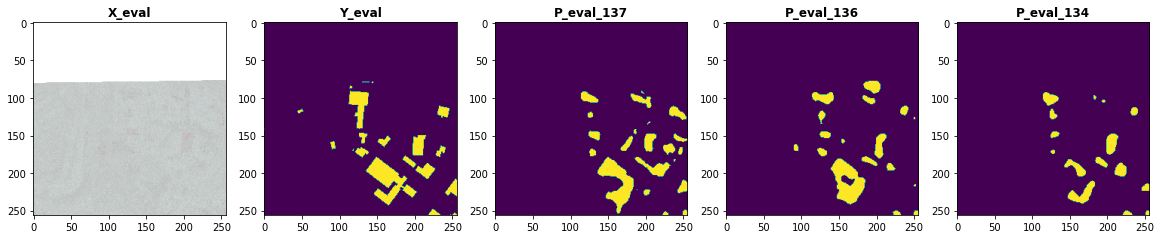

index: 50
eval preds  set


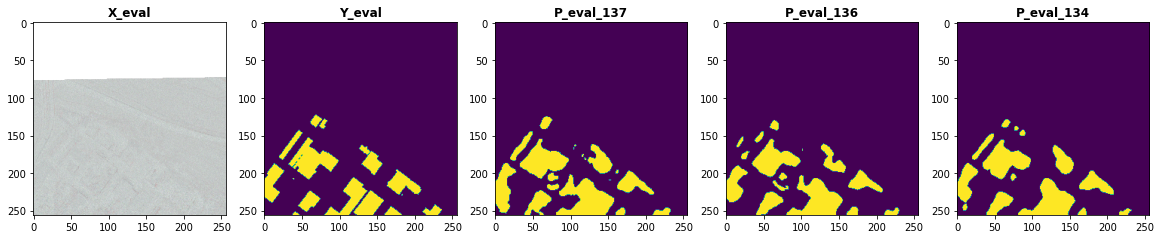

index: 56
eval preds  set


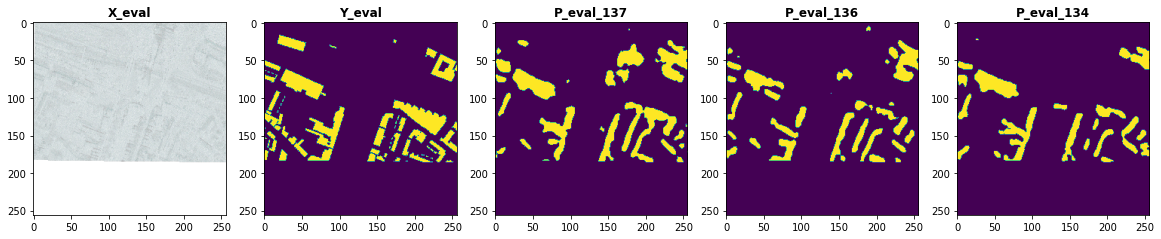

index: 167
eval preds  set


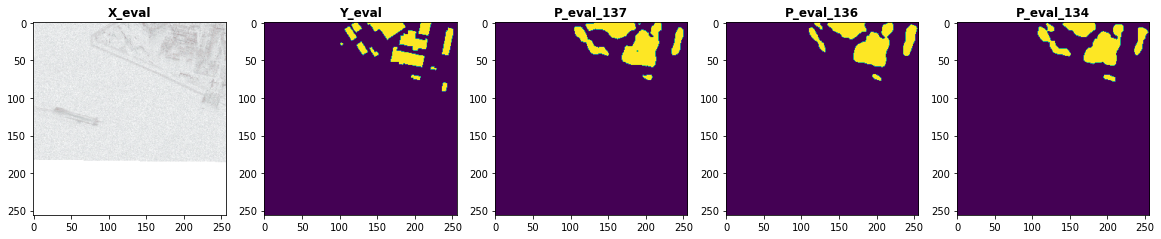

In [ ]:
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=2)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=49)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=50)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=56)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=167)

### Small, sparse and cannot predict
There are some images that have small and sparse buildings, and the models have a difficult time finding them. Big buildings tend to be identified with few issues. This is to be expected of course, smaller and sparser data have a smaller footprint and signal, hence naturall y harder to identify. 

However small buildings might actually be the most interesting ones

index: 4
eval preds  set


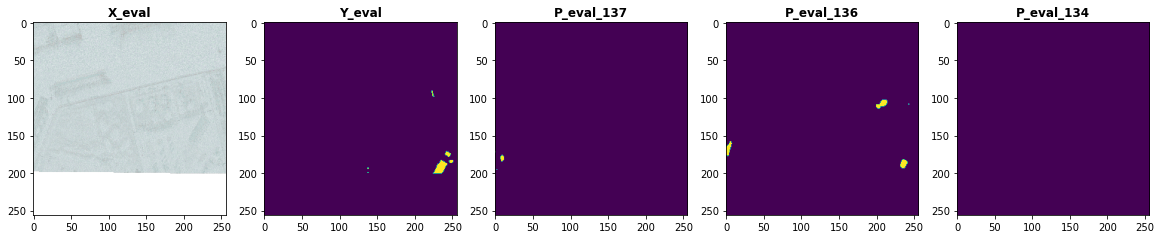

index: 18
eval preds  set


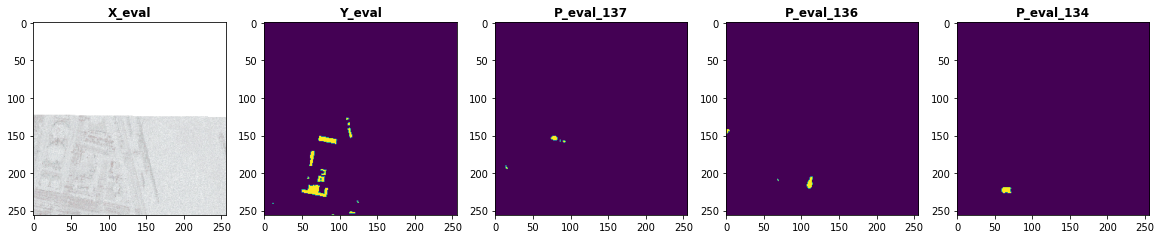

index: 61
eval preds  set


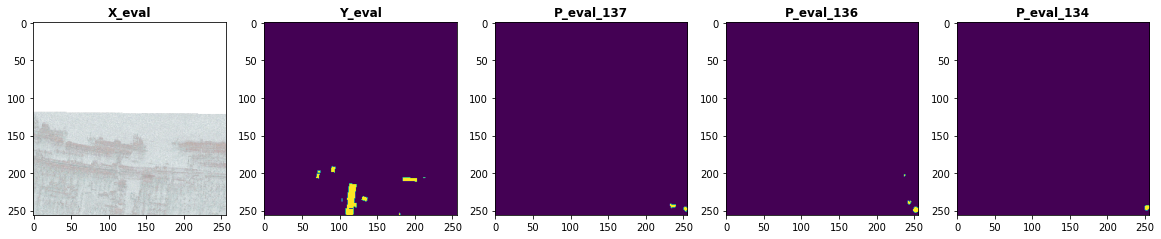

index: 76
eval preds  set


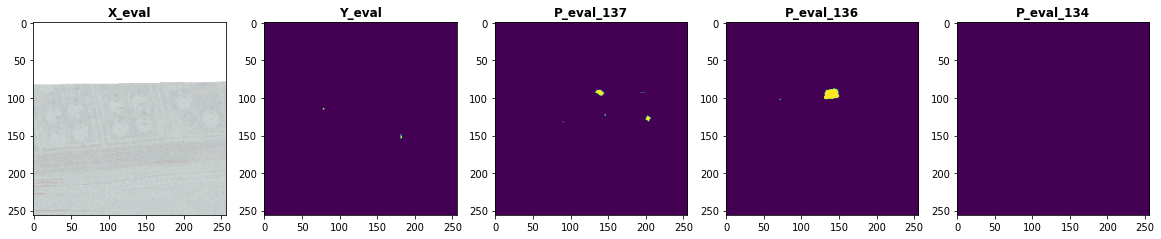

index: 77
eval preds  set


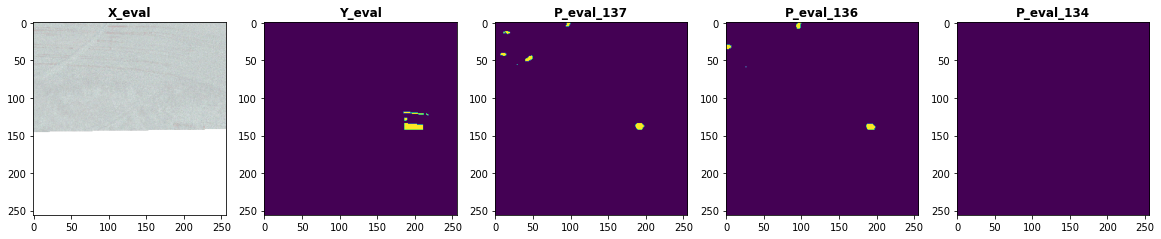

In [ ]:
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=4)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=18)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=61)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=76)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=77)
                      

### Fine building details
The resolution of the prediction is not strong at differentiating the finer details for a more complex building layout. Particularly when small building features are mixed in, the model cannot tell them apart. When many small buildings are grouped together, or close togehter, they tend to be predicted as one huge buiding instead. If a building has a small jutting-out area, or looks fuzzy, it tends to be overlooked by the models

index: 6
eval preds  set


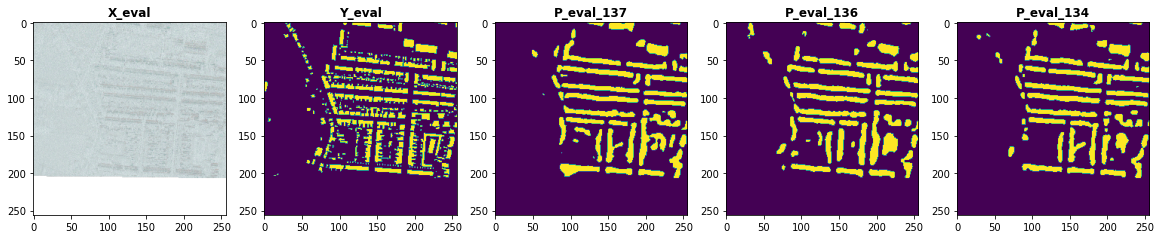

index: 7
eval preds  set


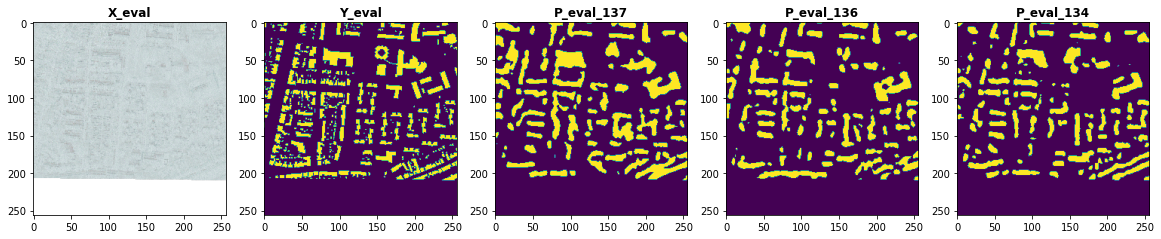

index: 10
eval preds  set


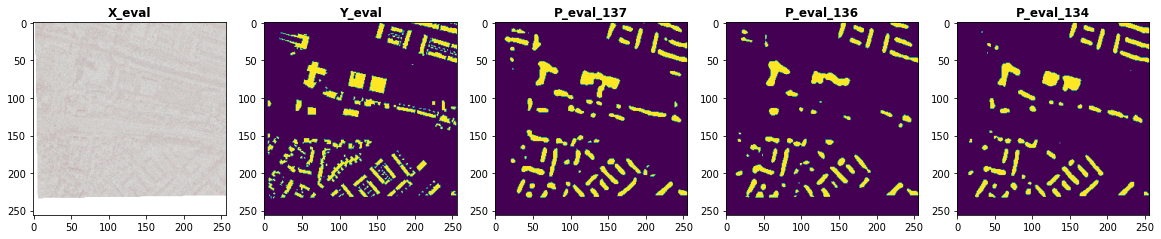

index: 85
eval preds  set


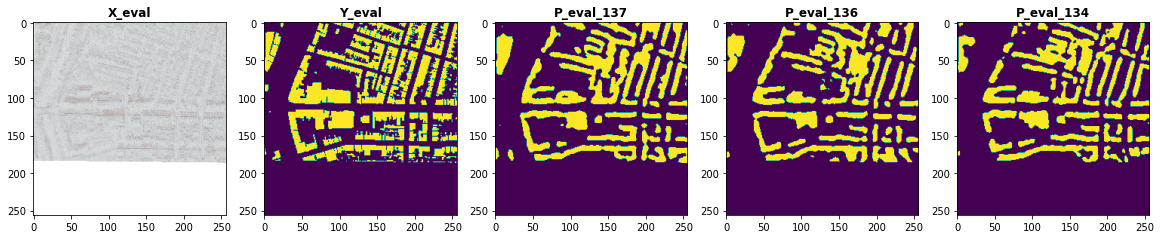

index: 88
eval preds  set


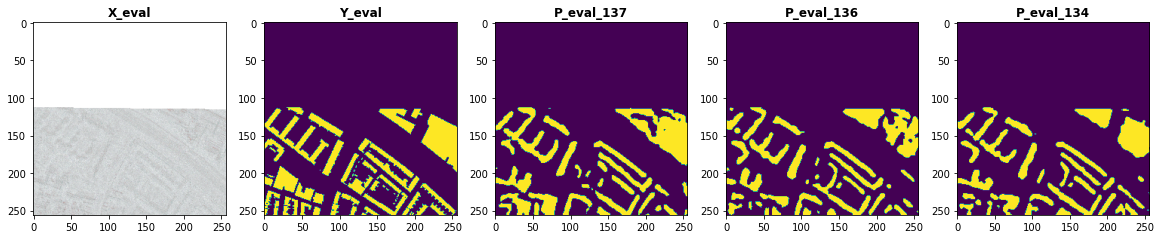

In [ ]:
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=6)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=7)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=10)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=85)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=88)
                      

### Blank turning up blank
There are images that have no buildings at all (blank). A lot of times, the predictions for these images also return no buildings. This is a good thing, we won't be assaulting buildings that don't exist

index: 53
eval preds  set


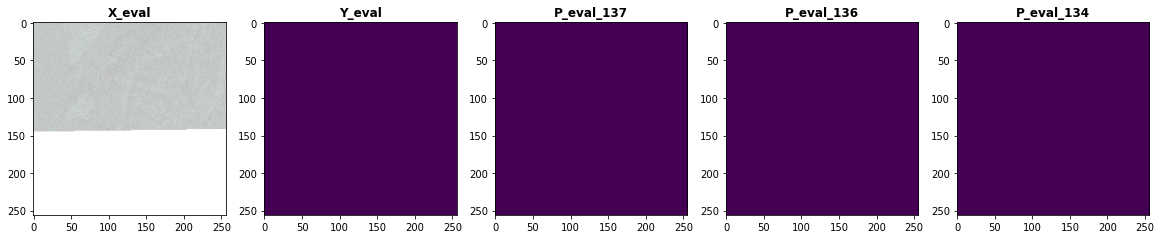

index: 54
eval preds  set


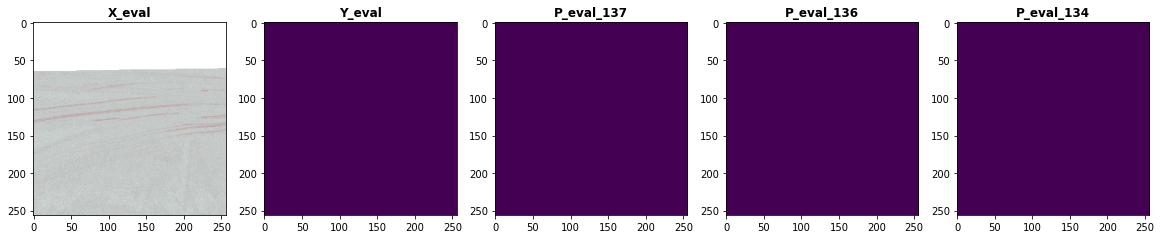

index: 55
eval preds  set


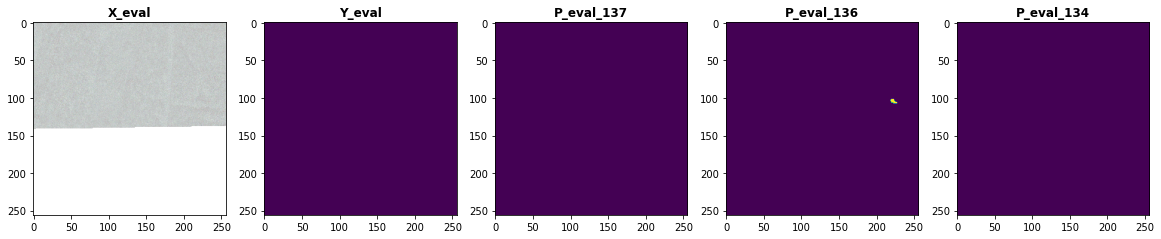

index: 110
eval preds  set


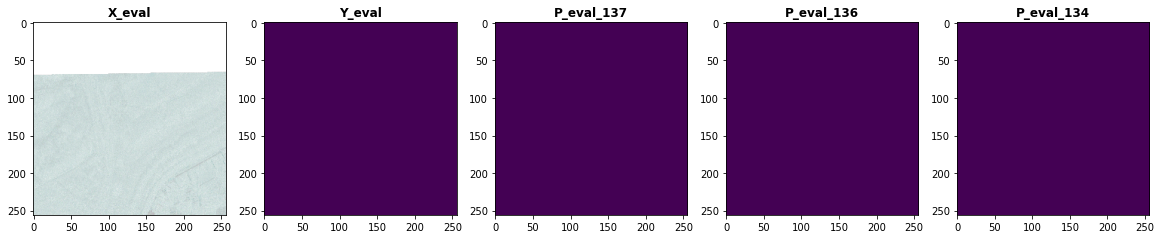

index: 112
eval preds  set


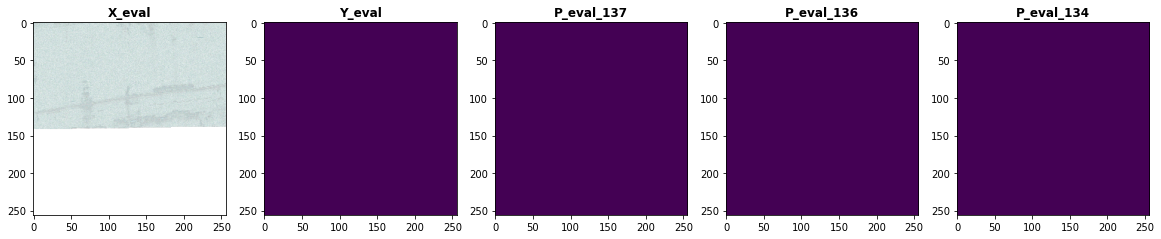

In [ ]:
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=53)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=54)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=55)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=110)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=112)

### Blank turning up something
There are also times when buildings are predicted, even though there aren't supposed to be any. It is often quite ok, but occasionally a huge building signature will be generated (index 217, 248) even when there aren't any. This is not a good thing since a random building in the middle of nowhere would be a point of interest, but it would actually be a waste of time and resources to investigate it since it does not exist


index: 82
eval preds  set


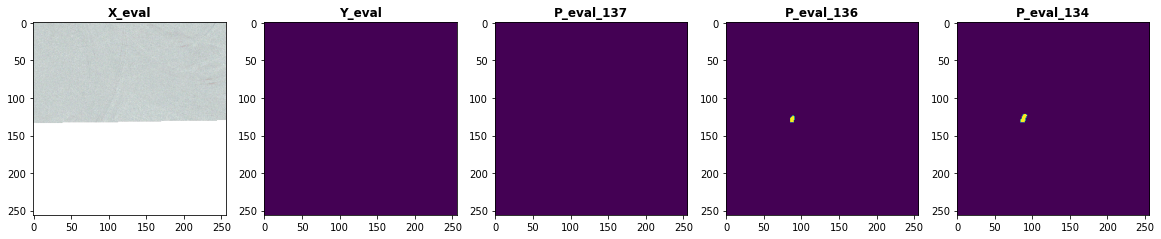

index: 109
eval preds  set


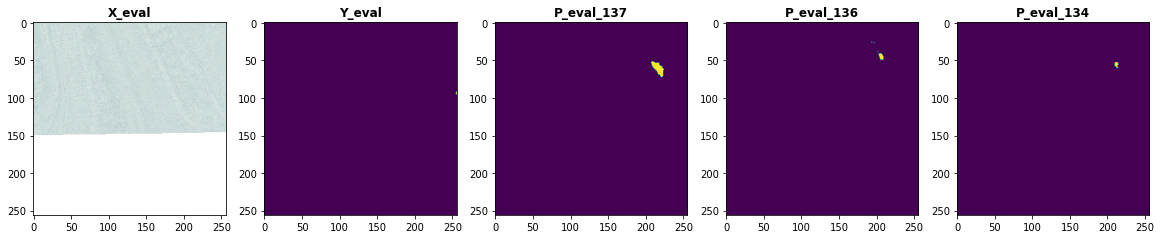

index: 217
eval preds  set


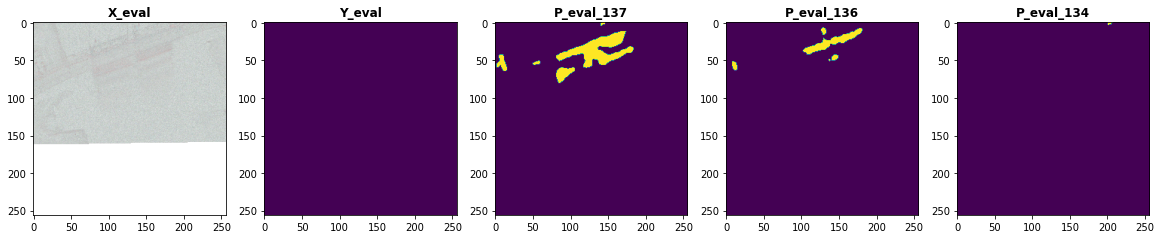

index: 248
eval preds  set


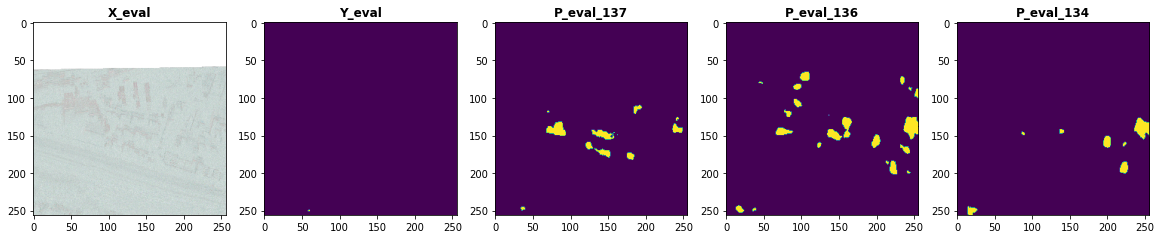

index: 382
eval preds  set


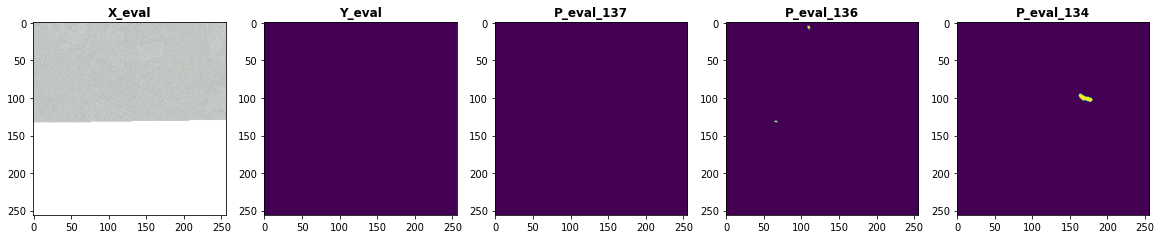

In [ ]:
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=82)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=109)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=217)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=248)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=382)

### Something turning up blank
There are definitely occasions where buildings exist on the ground truth image but not on the prediction. This is arguably the biggest problem since grounds of tactical importance will be missed entirely. This should be the wrong prediction that is minimised the most.

However most of these errors tend to be small buildings that the prediction misses. 


index: 170
eval preds  set


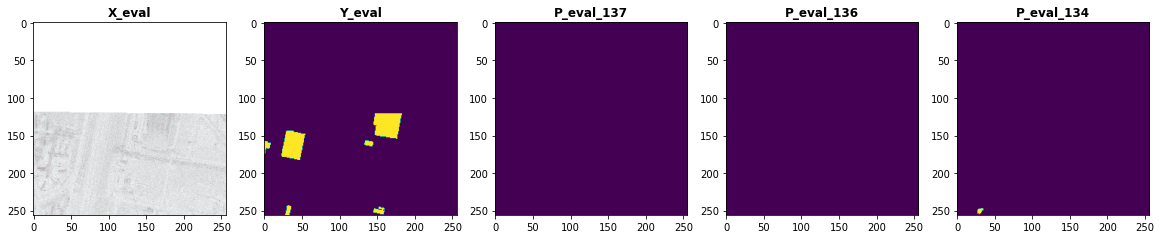

index: 207
eval preds  set


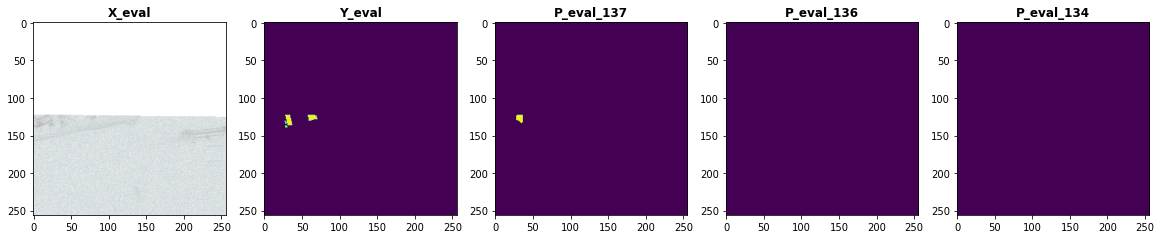

index: 308
eval preds  set


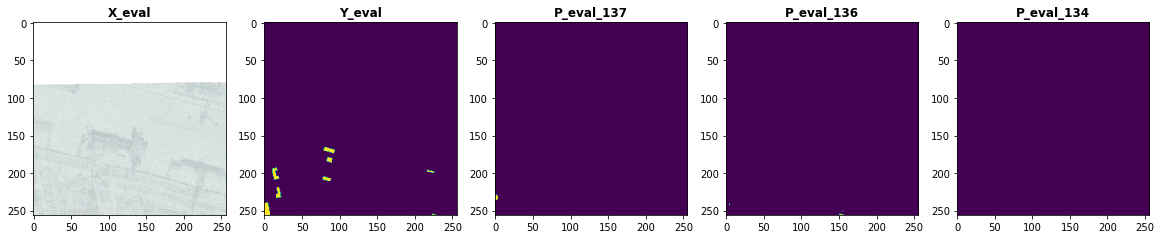

index: 406
eval preds  set


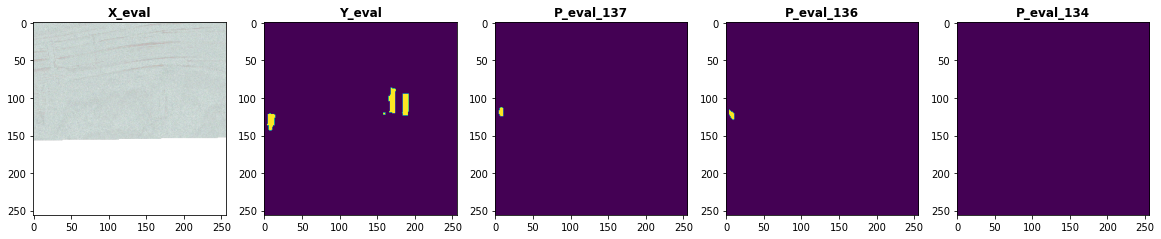

index: 437
eval preds  set


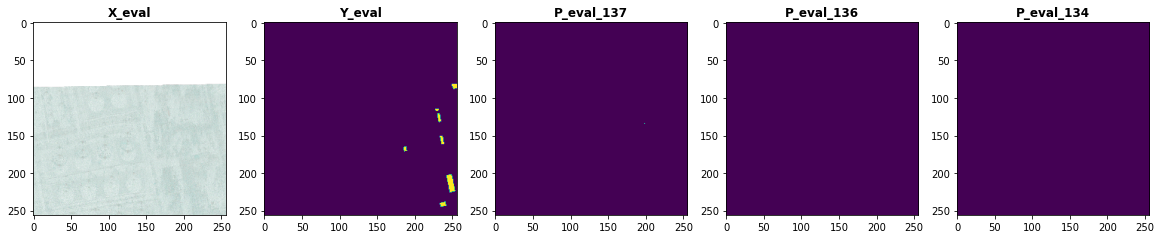

In [ ]:
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=170)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=207)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=308)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=406)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=437)

### Big misses
There are also certain images that are simply not predicted well, and constitutes big misses. These are images with high building signature yet get a bad prediction. Fixing this might help improve the model overall since there might be something about the SAR data that makes certain bigger buuildings harder to detect 

Also some images simply predict a wrong building somewhere, even with a building in the image

index: 532
eval preds  set


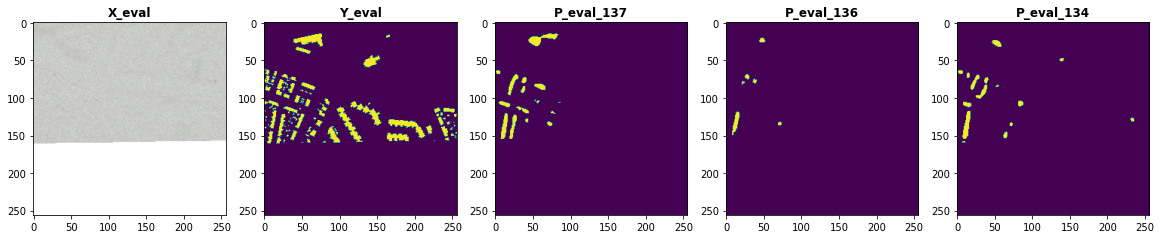

index: 559
eval preds  set


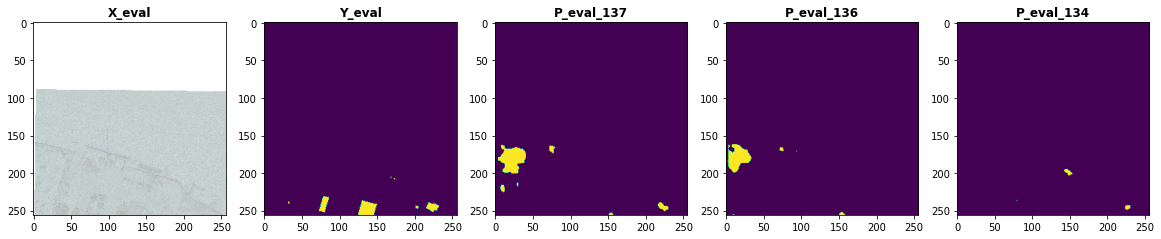

index: 591
eval preds  set


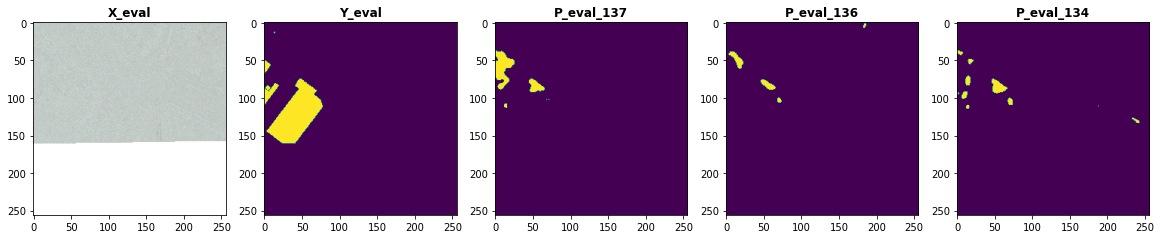

index: 755
eval preds  set


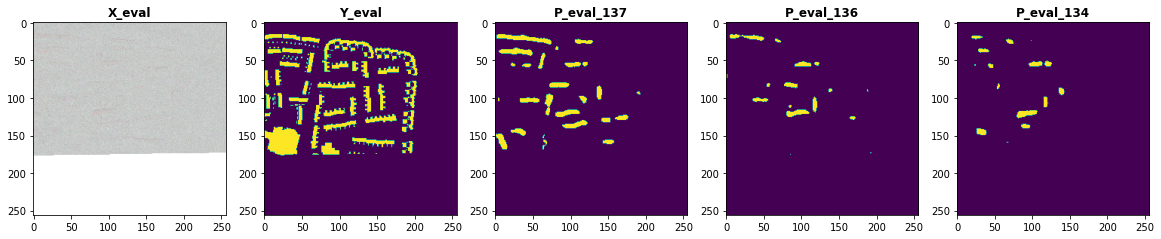

index: 759
eval preds  set


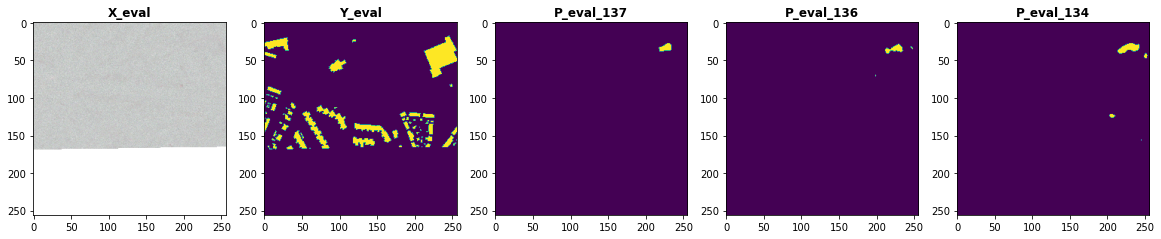

In [ ]:
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=532)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=559)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=591)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=755)
eval_top_models_preds('eval preds', X_eval, Y_eval, preds_eval_t_ID_137, preds_eval_t_ID_136, preds_eval_t_ID_134, 'X_eval', 'Y_eval', 'P_eval_137', 'P_eval_136', 'P_eval_134', index=759)

## Findings

Models actually look good! 


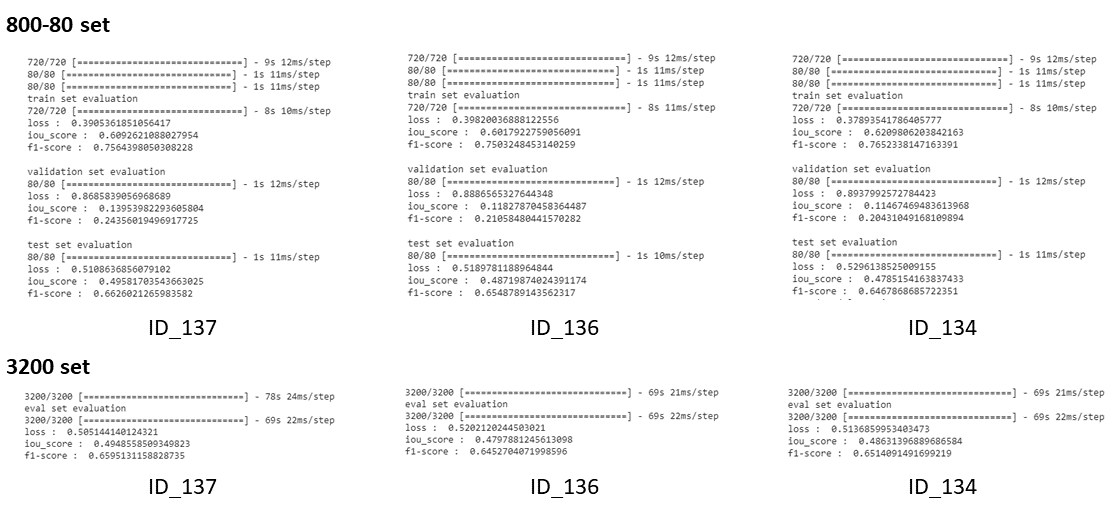

Condensed version

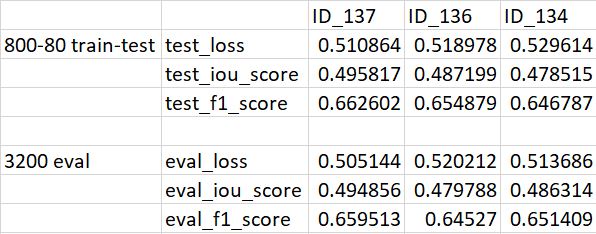

More can be done in the following areas:
1. Will transfer learning from EO images help? 
2. How to make the model try and predict along geometric shapes of buildings?
3. How to help the model separate the tiny buildings 
4. How to reduce the instances of models of model failing due to various reasons 
  * Blobby predictions
  * Small, sparse and cannot predict
  * Fine building details
  * Blank turning up something
  * Something turning up blank (might be the most important to reduce)
  * Big misses 
5. How to modify the model?
  * Prebuilt models were used in the project thus far, but extremely hard to customize. In fact, still unable to customize it  